In [1]:
import torch
import torch.utils.data
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pickle 

In [2]:
n_epochs = 50
batch_size_train = 128
batch_size_test = 1000
log_interval = 100
drop_rate = .6
random_seed = np.random.randint(low=1,high=1000000000)
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)



In [3]:
train_loader = torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('/files/', train=True,download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                        batch_size=batch_size_train, shuffle=True,pin_memory=True,num_workers=0)

test_loader = torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('/files/', train=False, download=True,
                                                     transform=torchvision.transforms.Compose([
                                                       torchvision.transforms.ToTensor(),
                                                       torchvision.transforms.Normalize(
                                                         (0.1307,), (0.3081,))
                                                     ])),
                        batch_size=batch_size_test, shuffle=False,pin_memory=True,num_workers=0)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

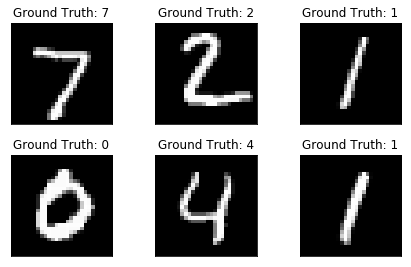

In [5]:

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Net(nn.Module):
    def __init__(self,drop):
        super(Net, self).__init__()
        self.regularization = nn.Dropout(drop/2)
        self.block1 = Basic_Block(1,drop).cuda()
        self.block2 = Basic_Block(32,drop).cuda()
        self.fc1 = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.regularization(x)
        x = self.block1(x)
        x = self.block2(x)
        x = Flatten()(x)
        x = self.fc1(x)
        return F.log_softmax(x,-1)
    
class Basic_Block(nn.Module):
    def __init__(self,inp,drop):
        super(Basic_Block, self).__init__()
        self.conv1 = nn.Conv2d(inp, 32, kernel_size=5,padding=2)
        self.regularization = nn.Dropout(drop)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5,padding=2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.regularization(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = self.regularization(x)
        return x

In [7]:
network = Net(drop_rate)
network = network.cuda()
optimizer = optim.Adam(network.parameters())

In [8]:
train_losses = []
train_correct = []
train_counter = []
test_losses = []
test_counter = []
test_correct = []

In [9]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.cuda()
            target  = target.cuda()
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        test_correct.append(correct)

In [10]:
def train(epoch):
    network.train()
    correct =0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target  = target.cuda()
        optimizer.zero_grad()
        output = network(data)
        pred = output.data.max(1, keepdim=True)[1]     
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx%(2*log_interval)==0:
            test()
            test_counter.append((batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
            
        correct+=pred.eq(target.data.view_as(pred)).sum().item()
        train_losses.append(loss.item())
        train_correct.append(correct)
        train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
    
    train_correct.append(correct)


In [11]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    print('Train Epoch: {} Loss: {:.6f} Val_Loss:{:.6f} Val_Acc:{:.2%}'.format(
        epoch, train_losses[-1],test_losses[-1],test_correct[-1]/len(test_loader.dataset)))
    test_counter.append(epoch*len(train_loader.dataset))


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 Loss: 0.003221 Val_Loss:0.047447 Val_Acc:98.37%
Train Epoch: 2 Loss: 0.018138 Val_Loss:0.041687 Val_Acc:98.73%
Train Epoch: 3 Loss: 0.044732 Val_Loss:0.024467 Val_Acc:99.12%
Train Epoch: 4 Loss: 0.016753 Val_Loss:0.023385 Val_Acc:99.18%
Train Epoch: 5 Loss: 0.114892 Val_Loss:0.023409 Val_Acc:99.34%
Train Epoch: 6 Loss: 0.002744 Val_Loss:0.023371 Val_Acc:99.33%
Train Epoch: 7 Loss: 0.066493 Val_Loss:0.024887 Val_Acc:99.34%
Train Epoch: 8 Loss: 0.000588 Val_Loss:0.029569 Val_Acc:99.18%
Train Epoch: 9 Loss: 0.049338 Val_Loss:0.029609 Val_Acc:99.11%
Train Epoch: 10 Loss: 0.000311 Val_Loss:0.029818 Val_Acc:99.14%
Train Epoch: 11 Loss: 0.000029 Val_Loss:0.035765 Val_Acc:99.27%
Train Epoch: 12 Loss: 0.000261 Val_Loss:0.042579 Val_Acc:98.92%
Train Epoch: 13 Loss: 0.018449 Val_Loss:0.026551 Val_Acc:99.31%
Train Epoch: 14 Loss: 0.010977 Val_Loss:0.028332 Val_Acc:99.26%
Train Epoch: 15 Loss: 0.000566 Val_Loss:0.022629 Val_Acc:99.26%
Train Epoch: 16 Loss: 0.002903 Val_Loss:0.026531 

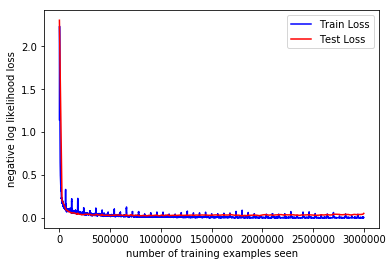

In [17]:
fig = plt.figure()
plt.plot(train_counter,np.convolve(train_losses,np.ones((20,))/20,mode='same'), color='blue')
plt.plot(test_counter,test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

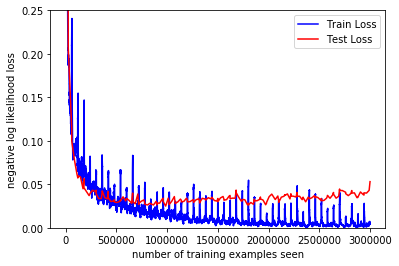

In [18]:
fig = plt.figure()
plt.plot(train_counter,np.convolve(train_losses,np.ones((40,))/40,mode='same'), color='blue')
plt.plot(test_counter,test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.ylim([0,0.25])
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [16]:
with open('/data/baseline_{}'.format(random_seed),'wb') as f:
    pickle.dump([train_losses,train_correct,train_counter,test_losses,test_counter,test_correct],f)

In [19]:
with torch.no_grad():
    output = network(example_data.cuda())

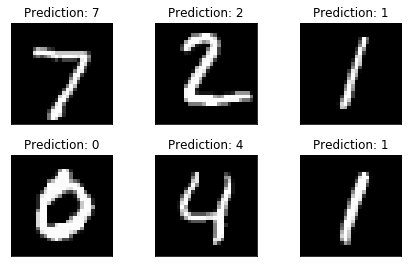

In [20]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0].cuda(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()